# FNN

In [1]:
import torch
from torchtext import data

SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True,
                  pad_first=True)
LABEL = data.LabelField(dtype = torch.float)

In [2]:
from torchtext import datasets

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

print(vars(train_data.examples[0]))

Number of training examples: 25000
Number of testing examples: 25000
{'text': ['City', 'Hall', 'takes', 'on', 'the', 'politics', 'of', 'a', 'city', 'rather', 'than', 'country', ',', 'state', 'or', 'any', 'sort', 'of', 'major', 'political', 'table', '.', 'Granted', 'it', 'shines', 'on', 'New', 'York', 'City', 'which', 'is', 'a', 'huge', 'political', 'arena', ',', 'especially', 'nowadays', ',', 'but', 'it', 'still', 'goes', 'for', 'a', 'smaller', 'scale', 'and', 'puts', 'the', 'microscope', 'on', 'a', 'few', 'key', 'players', 'in', 'a', 'city', 'wide', 'scandal', 'stumbled', 'on', 'by', 'the', 'mayor', "'s", 'right', 'hand', '.', 'Director', 'Harold', 'Becker', 'is', 'a', 'director', 'very', 'familiar', 'with', 'elements', 'of', 'the', 'thriller', 'having', 'done', 'Mercury', 'Rising', ',', 'Malice', ',', 'and', 'Domestic', 'Disturbance', 'and', 'I', 'think', 'in', 'many', 'ways', 'he', 'incorporates', 'so', 'many', 'of', 'the', 'formulaic', 'thriller', 'genre', 'that', 'its', 'almost', 

In [3]:
import random

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [4]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, max_size = MAX_VOCAB_SIZE)
LABEL.build_vocab(train_data)

print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

print(TEXT.vocab.itos[:10])

print(LABEL.vocab.stoi)

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2
['<unk>', '<pad>', 'the', ',', '.', 'a', 'and', 'of', 'to', 'is']
defaultdict(None, {'neg': 0, 'pos': 1})


In [5]:
TEXT.__dict__

{'sequential': True,
 'use_vocab': True,
 'init_token': None,
 'eos_token': None,
 'unk_token': '<unk>',
 'fix_length': None,
 'dtype': torch.int64,
 'preprocessing': None,
 'postprocessing': None,
 'lower': False,
 'tokenizer_args': ('spacy', 'en_core_web_sm'),
 'tokenize': functools.partial(<function _spacy_tokenize at 0x7f147a61e0c0>, spacy=<spacy.lang.en.English object at 0x7f145f4cf5d0>),
 'include_lengths': True,
 'batch_first': False,
 'pad_token': '<pad>',
 'pad_first': True,
 'truncate_first': False,
 'stop_words': None,
 'is_target': False,
 'vocab': <torchtext.vocab.Vocab at 0x7f1426e1f450>}

In [6]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    sort_within_batch = True,
    device = device)

## Build the Model

In [8]:
import numpy as np
import torch.nn as nn

class FNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dims, output_dim):
        
        super().__init__()
    
        self.embedding = nn.EmbeddingBag(input_dim, embedding_dim, sparse=False)

        self.num_layers = len(hidden_dims)

        if self.num_layers == 1:
          self.L1 = nn.Linear(embedding_dim, hidden_dims[0])
          self.FL = nn.Linear(hidden_dims[0], output_dim)
        
        elif self.num_layers == 2:
          self.L1 = nn.Linear(embedding_dim, hidden_dims[0])
          self.L2 = nn.Linear(hidden_dims[0], hidden_dims[1])
          self.FL = nn.Linear(hidden_dims[1], output_dim)
        
        elif self.num_layers == 3:
          self.L1 = nn.Linear(embedding_dim, hidden_dims[0])
          self.L2 = nn.Linear(hidden_dims[0], hidden_dims[1])
          self.L3 = nn.Linear(hidden_dims[1], hidden_dims[2])
          self.FL = nn.Linear(hidden_dims[2], output_dim)
        
        else:
          print('Class FNN module only supports up to 3 hidden layers')
        
        
    def forward(self, text, text_lengths):
        #text = [sent len, batch size]

        text = torch.transpose(text,0,1)
        # text = [batch size, sent len]
       
        embedded = self.embedding(text)
        # embedded = [batch size, embedding_dim]

        if self.num_layers == 1:
          output = self.L1(embedded)
          # output = self.act(output)
        
        elif self.num_layers == 2:
          output = self.L1(embedded)
          # output = self.act(output)
          output = self.L2(output)
          # output = self.act(output)
        
        else:
          output = self.L1(embedded)
          # output = self.act(output)
          output = self.L2(output)
          # output = self.act(output)
          output = self.L3(output)
          # output = self.act(output)
        
        return self.FL(output.squeeze(0)) # [batch size, 1]

## Train the Model

In [9]:
import torch.optim as optim
criterion = nn.BCEWithLogitsLoss()
criterion = criterion.to(device)

In [10]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [11]:
def train(model, iterator, optimizer, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:

        optimizer.zero_grad()

        text, text_lengths = batch.text

        predictions = model(text, text_lengths).squeeze(1)

        loss = criterion(predictions, batch.label)

        acc = binary_accuracy(predictions, batch.label)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [13]:
def evaluate(model, iterator, criterion):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for batch in iterator:
            text, text_lengths = batch.text

            predictions = model(text, text_lengths).squeeze(1)

            loss = criterion(predictions, batch.label)

            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [14]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Feed Forward Neural Network with 1 Layers:
Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.566 | Train Acc: 69.98%
	 Val. Loss: 0.494 |  Val. Acc: 78.54%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.379 | Train Acc: 84.91%
	 Val. Loss: 0.355 |  Val. Acc: 84.95%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.260 | Train Acc: 89.70%
	 Val. Loss: 0.349 |  Val. Acc: 86.59%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.237 | Train Acc: 92.31%
	 Val. Loss: 0.307 |  Val. Acc: 87.98%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.151 | Train Acc: 94.80%
	 Val. Loss: 0.335 |  Val. Acc: 87.80%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.170 | Train Acc: 94.77%
	 Val. Loss: 0.342 |  Val. Acc: 87.84%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.139 | Train Acc: 96.40%
	 Val. Loss: 0.406 |  Val. Acc: 87.33%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.117 | Train Acc: 97.26%
	 Val. Loss: 0.359 |  Val. Acc: 88.29%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.097 | Train Acc: 97.94%
	 Val. Loss: 0.381 |  Va

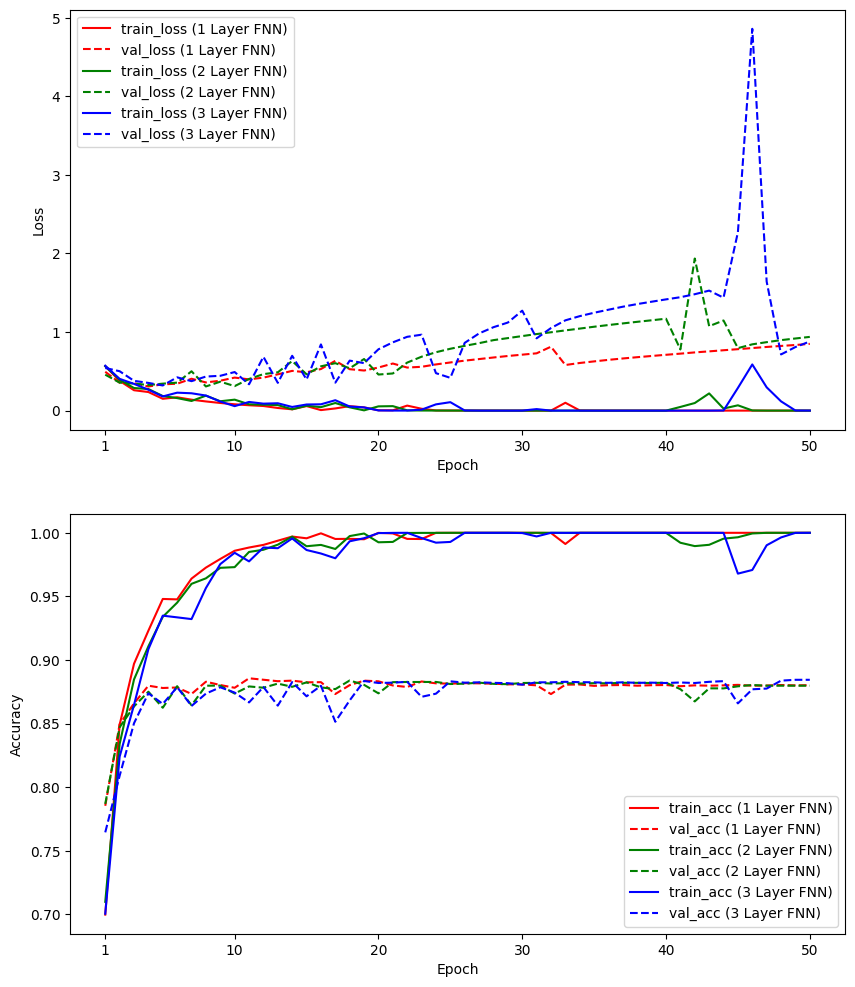

In [15]:
import matplotlib.pyplot as plt

N_EPOCHS = 50

INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
HIDDEN_DIM = [[500], [500,300], [500,300,200]]
OUTPUT_DIM = 1

colors_train = ['r-', 'g-', 'b-']
colors_val = ['r--', 'g--', 'b--']
plot_labels = ['(1 Layer FNN)', '(2 Layer FNN)', '(3 Layer FNN)']

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,12))
ax1.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xticks([0,9,19,29,39,49], labels=[1,10,20,30,40,50])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')

train_loss_FNN = np.zeros([50, 3])
train_acc_FNN = np.zeros([50, 3])
val_loss_FNN = np.zeros([50, 3])
val_acc_FNN = np.zeros([50, 3])

for i in range(3):
    print(f'Feed Forward Neural Network with {i+1} Layers:')
    model_FNN = FNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM[i], OUTPUT_DIM)
    optimizer_Adam = optim.Adam(model_FNN.parameters(), lr=1e-3)
    model_FNN = model_FNN.to(device)

    best_valid_loss = float('inf')

    for epoch in range(N_EPOCHS):

        start_time = time.time()
        
        train_loss, train_acc = train(model_FNN, train_iterator, optimizer_Adam, criterion)
        valid_loss, valid_acc = evaluate(model_FNN, valid_iterator, criterion)
        
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model_FNN.state_dict(), 'model_FNN.pt')
        
        train_loss_FNN[epoch, i] = train_loss
        train_acc_FNN[epoch, i] = train_acc
        val_loss_FNN[epoch, i] = valid_loss
        val_acc_FNN[epoch, i] = valid_acc

        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
    
    ax1.plot(train_loss_FNN[:,i], colors_train[i], label='train_loss '+plot_labels[i])
    ax1.plot(val_loss_FNN[:,i], colors_val[i], label='val_loss '+plot_labels[i])
    ax2.plot(train_acc_FNN[:,i], colors_train[i], label='train_acc '+plot_labels[i])
    ax2.plot(val_acc_FNN[:,i], colors_val[i], label='val_acc '+plot_labels[i])

    print(f'Training completed')
    print(f'Test:')

    model_FNN.load_state_dict(torch.load('model_FNN.pt'))
    test_loss, test_acc = evaluate(model_FNN, test_iterator, criterion)
    print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')
    print('------------------')


ax1.legend()
ax2.legend()